In [0]:
import tensorflow as tf
import gym
import numpy as np

In [0]:
class Agent:
    def __init__(self, learning_rate):
        # Build the network to predict the correct action
        tf.reset_default_graph()
        input_dimension = 4
        hidden_dimension = 20
        self.input = tf.placeholder(dtype=tf.float32, 
                                    shape=[1, input_dimension], 
                                    name='X')
        w1 = tf.get_variable(name='weight_of_hiddern_layer',
                             shape=[input_dimension, hidden_dimension],
                             initializer=tf.initializers.glorot_normal())
        w2 = tf.get_variable(name="weight_of_last_layer",
                             shape=[hidden_dimension, 2], 
                             initializer=tf.initializers.glorot_normal())
        b1 = tf.get_variable(name="bias_of_hiddern_layer",
                             shape=[hidden_dimension, ], 
                             initializer=tf.initializers.zeros())
        b2 = tf.get_variable(name="bias_of_last_layer",
                             shape=[2, ], initializer=tf.initializers.zeros())
        hidden_layer = tf.nn.leaky_relu(self.input @ w1 + b1, 0.2)
        
        self.logits = hidden_layer @ w2 + b2

        # Sample an action according to network's output
        self.action = tf.multinomial(tf.log(tf.nn.softmax(self.logits)), 
                                     num_samples=1)

        # Optimization according to policy gradient algorithm
        label = tf.roll(tf.eye(num_rows=1, num_columns=2), 
                        shift=self.action[0][0], axis=1)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=label)
        self.optimizer = tf.train.AdamOptimizer(learning_rate) 
        # gradient of current action w.r.t. network's variables
        grads_vars = self.optimizer.compute_gradients(cross_entropy)  
        self.gradients = [grad for grad, var in grads_vars]

        # get rewards from the environment and evaluate rewarded gradients
        #  and feed it to agent and then call train operation
        self.rewarded_grads_placeholders_list = []
        rewarded_grads_and_vars = []
        for grad, var in grads_vars:
            rewarded_grad_placeholder = tf.placeholder(dtype=tf.float32, shape=grad.shape)
            self.rewarded_grads_placeholders_list.append(rewarded_grad_placeholder)
            rewarded_grads_and_vars.append((rewarded_grad_placeholder, var))

        self.train_operation = self.optimizer.apply_gradients(rewarded_grads_and_vars)

        self.saver = tf.train.Saver()

        config = tf.ConfigProto(
            device_count={'GPU': 0}
        )

        self.ses = tf.Session(config=config)
        self.ses.run(tf.global_variables_initializer())

    def get_action_and_gradients(self, obs):
        action, gradients = self.ses.run([self.action, self.gradients], 
                                         feed_dict={self.input: np.asarray(obs)[np.newaxis]})
        return action[0][0], gradients

    def train(self, rewarded_gradients):
        feed_dict = {item: rewarded_gradients[i] for i, item in enumerate(self.rewarded_grads_placeholders_list)}
        self.ses.run(self.train_operation, feed_dict=feed_dict)
        
    def save(self):
        self.saver.save(self.ses, "SavedModel/")

    def load(self):
        self.saver.restore(self.ses, "SavedModel/")

In [0]:
epochs = 1500
max_steps_per_game = 1000
games_per_epoch = 20
discount_factor = 0.95
learning_rate = 0.01

In [17]:
agent = Agent(learning_rate)
game = gym.make("CartPole-v0").env
for epoch in range(epochs):
    epoch_rewards = []
    epoch_gradients = []
    epoch_average_reward = 0
    for episode in range(games_per_epoch):
        obs = game.reset()
        step = 0
        single_episode_rewards = []
        single_episode_gradients = []
        game_over = False
        while not game_over and step < max_steps_per_game:
            step += 1
            # image = game.render(mode='rgb_array') # Call this to render game and show visual
            action, gradients = agent.get_action_and_gradients(obs)
            obs, reward, game_over, info = game.step(action)
            single_episode_rewards.append(reward)
            single_episode_gradients.append(gradients)

        epoch_rewards.append(single_episode_rewards)
        epoch_gradients.append(single_episode_gradients)
        epoch_average_reward += sum(single_episode_rewards)

    epoch_average_reward /= games_per_epoch
    print("Epoch = {} \t Average reward = {}".format(epoch, epoch_average_reward))
    
    if epoch_average_reward>=900:
        print ("Early stop trick")
        validation_game_number = 100
        epoch_average_reward_Test = 0
        step = 0
        for episode in range(validation_game_number):
            obs = game.reset()
            game_over = False
            while not game_over and step < max_steps_per_game:
                step += 1
                action, _ = agent.get_action_and_gradients(obs)
                obs, _, game_over, _ = game.step(action)
            epoch_average_reward_Test += step
        epoch_average_reward_Test /= validation_game_number
        if epoch_average_reward_Test>=900:
            print("Validation score = {}, Model stopped".format(epoch_average_reward_Test))
            break
        else:
            print ("Validation score isn't enough, Validation score = {} ".format(epoch_average_reward_test))
        
    base_line = np.mean([(1 - discount_factor**(item2 + 1))/(1 - discount_factor) 
                         for item2 in [len(item) for item in epoch_rewards]])

    normalized_rewards = [(1 - discount_factor**(item2 + 1))/(1 - discount_factor) - base_line 
                          for item2 in range(max([len(item) for item in epoch_rewards]))]
    
    position = np.zeros_like(epoch_gradients[0][0][0])
    velocity = np.zeros_like(epoch_gradients[0][0][1])
    angle = np.zeros_like(epoch_gradients[0][0][2])
    angular_velocity = np.zeros_like(epoch_gradients[0][0][3])
    for episode_gradients in epoch_gradients:
        for i, time_grad in enumerate(episode_gradients):
            temp = list()
            for j in time_grad:
                temp.append(j * normalized_rewards[-1 - i])
            position += temp[0]
            velocity += temp[1]
            angle += temp[2]
            angular_velocity += temp[3]
    
    mean_rewarded_gradients = [position/games_per_epoch, 
                               velocity/games_per_epoch, 
                               angle/games_per_epoch, 
                               angular_velocity/games_per_epoch]

    agent.train(mean_rewarded_gradients)

agent.save()
game.close()

Epoch = 0 	 Average reward = 24.1
Epoch = 1 	 Average reward = 21.95
Epoch = 2 	 Average reward = 22.85
Epoch = 3 	 Average reward = 18.6
Epoch = 4 	 Average reward = 31.25
Epoch = 5 	 Average reward = 24.45
Epoch = 6 	 Average reward = 23.0
Epoch = 7 	 Average reward = 24.0
Epoch = 8 	 Average reward = 29.65
Epoch = 9 	 Average reward = 22.95
Epoch = 10 	 Average reward = 26.7
Epoch = 11 	 Average reward = 26.85
Epoch = 12 	 Average reward = 26.6
Epoch = 13 	 Average reward = 24.55
Epoch = 14 	 Average reward = 21.8
Epoch = 15 	 Average reward = 24.9
Epoch = 16 	 Average reward = 21.0
Epoch = 17 	 Average reward = 28.65
Epoch = 18 	 Average reward = 32.0
Epoch = 19 	 Average reward = 23.7
Epoch = 20 	 Average reward = 25.35
Epoch = 21 	 Average reward = 24.25
Epoch = 22 	 Average reward = 25.3
Epoch = 23 	 Average reward = 26.95
Epoch = 24 	 Average reward = 24.45
Epoch = 25 	 Average reward = 33.35
Epoch = 26 	 Average reward = 27.75
Epoch = 27 	 Average reward = 31.05
Epoch = 28 	 A

In [18]:
agent = Agent(0)
game = gym.make("CartPole-v0").env
agent.load()
score = 0
for i in range(10):
    obs = game.reset()
    game_over = False
    while not game_over:
        score += 1
#         image = game.render(mode='rgb_array')  # Call this to render game and show visual
        action, _ = agent.get_action_and_gradients(obs)
        obs, reward, game_over, info = game.step(action)

print("Average Score = ", score / 10)

INFO:tensorflow:Restoring parameters from SavedModel/
Average Score =  20534.4


In [8]:
discount_factors = np.array([0.99, 0.9, 0.5, 0.1])
games_per_epoch = 10
rewards = np.zeros(shape=(discount_factors.shape[0], epochs))
stopped_epoch_number = np.ones(shape=(discount_factors.shape[0],))*epochs
for iDisc in range(discount_factors.shape[0]):
    discount_factor = discount_factors[iDisc]
    print("----------- Discount Factor = {} -----------".format(discount_factor))
    
    agent = Agent(learning_rate)
    game = gym.make("CartPole-v0").env
    for epoch in range(epochs):
        epoch_rewards = []
        epoch_gradients = []
        epoch_average_reward = 0
        for episode in range(games_per_epoch):
            obs = game.reset()
            step = 0
            single_episode_rewards = []
            single_episode_gradients = []
            game_over = False
            while not game_over and step < max_steps_per_game:
                step += 1
                # image = game.render(mode='rgb_array') # Call this to render game and show visual
                action, gradients = agent.get_action_and_gradients(obs)
                obs, reward, game_over, info = game.step(action)
                single_episode_rewards.append(reward)
                single_episode_gradients.append(gradients)

            epoch_rewards.append(single_episode_rewards)
            epoch_gradients.append(single_episode_gradients)
            epoch_average_reward += sum(single_episode_rewards)

        epoch_average_reward /= games_per_epoch
        print("Epoch = {} \t Average reward = {}".format(epoch, epoch_average_reward))
        rewards[iDisc, epoch] = epoch_average_reward

        if epoch_average_reward>=900:
            print ("Early stop trick")
            validation_game_number = 100
            epoch_average_reward_test = 0
            for episode in range(validation_game_number):
                step = 0
                obs = game.reset()
                game_over = False
                while not game_over and step < max_steps_per_game:
                    step += 1
                    action, _ = agent.get_action_and_gradients(obs)
                    obs, _, game_over, _ = game.step(action)
                epoch_average_reward_test += step
            epoch_average_reward_test /= validation_game_number
            if epoch_average_reward_test>=900:
                print("Validation score = {}, Model stopped".format(epoch_average_reward_test))
                stopped_epoch_number[iDisc] = epoch
                break
            else:
                print ("Validation score isn't enough, Validation score = {} ".format(epoch_average_reward_test))

        base_line = np.mean([(1 - discount_factor**(item2 + 1))/(1 - discount_factor) for item2 in [len(item) for item in epoch_rewards]])

        normalized_rewards = [(1 - discount_factor**(item2 + 1))/(1 - discount_factor) - base_line 
                              for item2 in range(max([len(item) for item in epoch_rewards]))]

        position = np.zeros_like(epoch_gradients[0][0][0])
        velocity = np.zeros_like(epoch_gradients[0][0][1])
        angle = np.zeros_like(epoch_gradients[0][0][2])
        angular_velocity = np.zeros_like(epoch_gradients[0][0][3])
        for episode_gradients in epoch_gradients:
            for i, time_grad in enumerate(episode_gradients):
                temp = list()
                for j in time_grad:
                    temp.append(j * normalized_rewards[-1 - i])
                position += temp[0]
                velocity += temp[1]
                angle += temp[2]
                angular_velocity += temp[3]

        mean_rewarded_gradients = [position/games_per_epoch, 
                                   velocity/games_per_epoch, 
                                   angle/games_per_epoch, 
                                   angular_velocity/games_per_epoch]

        agent.train(mean_rewarded_gradients)

    game.close()

----------- Discount Factor = 0.99 -----------
Epoch = 0 	 Average reward = 24.4
Epoch = 1 	 Average reward = 23.3
Epoch = 2 	 Average reward = 23.9
Epoch = 3 	 Average reward = 18.7
Epoch = 4 	 Average reward = 31.1
Epoch = 5 	 Average reward = 43.3
Epoch = 6 	 Average reward = 24.6
Epoch = 7 	 Average reward = 33.0
Epoch = 8 	 Average reward = 32.7
Epoch = 9 	 Average reward = 24.6
Epoch = 10 	 Average reward = 25.5
Epoch = 11 	 Average reward = 23.1
Epoch = 12 	 Average reward = 25.4
Epoch = 13 	 Average reward = 28.3
Epoch = 14 	 Average reward = 21.3
Epoch = 15 	 Average reward = 21.4
Epoch = 16 	 Average reward = 27.8
Epoch = 17 	 Average reward = 18.6
Epoch = 18 	 Average reward = 35.9
Epoch = 19 	 Average reward = 18.1
Epoch = 20 	 Average reward = 27.9
Epoch = 21 	 Average reward = 20.1
Epoch = 22 	 Average reward = 19.5
Epoch = 23 	 Average reward = 46.1
Epoch = 24 	 Average reward = 30.6
Epoch = 25 	 Average reward = 27.2
Epoch = 26 	 Average reward = 28.3
Epoch = 27 	 Avera

In [0]:
import matplotlib.pyplot as plt

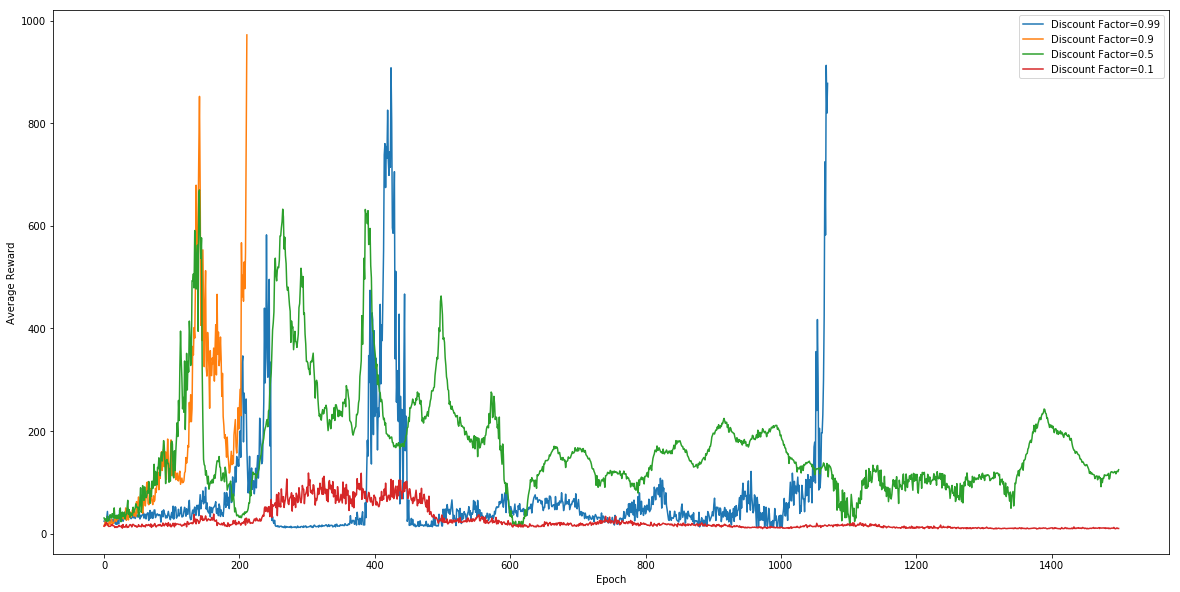

In [21]:
plt.figure(figsize=(20,10))
for i in range(discount_factors.shape[0]):
    plt.plot(np.arange(stopped_epoch_number[i]), 
             rewards[i,0:np.int32(stopped_epoch_number[i])], 
             label="Discount Factor={}".format(discount_factors[i]))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Reward")
plt.show()

INFO:tensorflow:Restoring parameters from SavedModel/
Probability of choosing left action


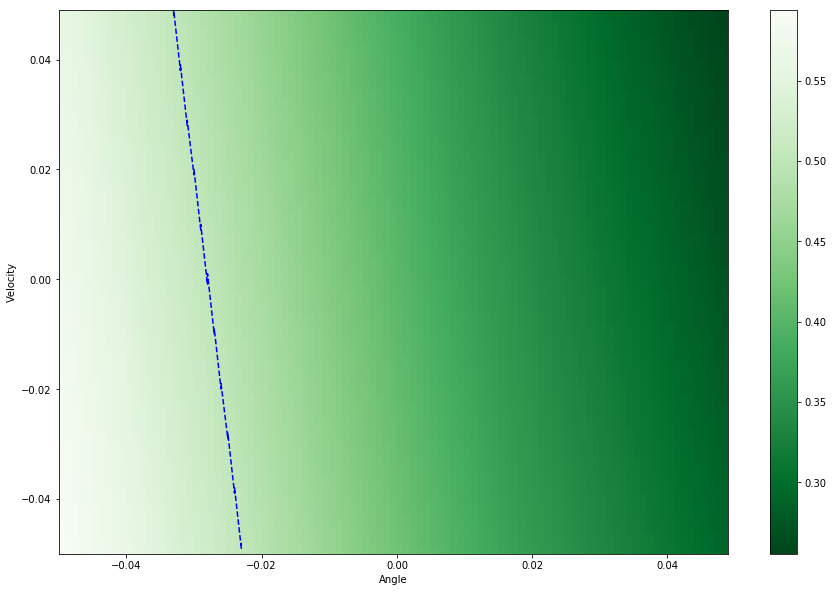

In [53]:
agent = Agent(learning_rate)
agent.load()
soft_max = tf.nn.softmax(agent.logits)

angle_range = np.arange(-0.05, 0.05, 0.001)
velocity_range = np.arange(-0.05, 0.05, 0.001)
angular_velocity_range = np.arange(-0.05, 0.05, 0.001)

x, y = np.meshgrid(angle_range, velocity_range)
data = np.concatenate((np.zeros_like(y)[np.newaxis], 
                          y[np.newaxis], 
                          x[np.newaxis],
                          np.zeros_like(y)[np.newaxis]), axis=0)
data = data.reshape((4,-1)).T
probability = np.zeros(shape=(data.shape[0],))
for i in range(data.shape[0]):
    probability[i] = agent.ses.run(soft_max, feed_dict={agent.input: data[i,:][np.newaxis]})[0][0]
probability = np.reshape(probability, (angle_range.shape[0], velocity_range.shape[0]), order='F')
line_x, line_y = np.where(np.abs(probability-0.5)<4e-4)
print("Probability of choosing left action")
plt.figure(figsize=(15,10))
plt.pcolormesh(angle_range, velocity_range, probability.T, cmap=plt.cm.Greens_r)
plt.colorbar()
plt.plot(angle_range[line_x],velocity_range[line_y],'b--')
plt.xlabel("Angle")
plt.ylabel("Velocity")
plt.show()

Probability of choosing left action


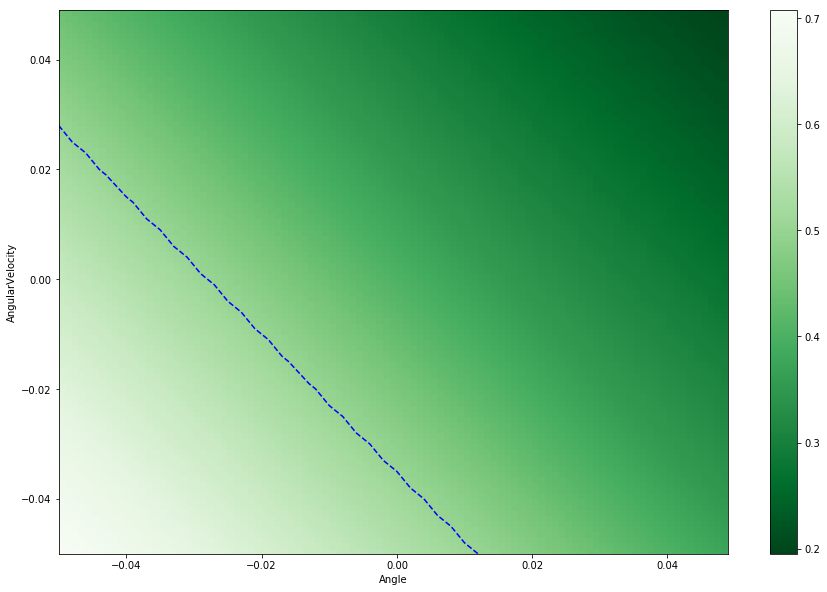

In [54]:
x, y = np.meshgrid(angle_range, angular_velocity_range)
data = np.concatenate((np.zeros_like(y)[np.newaxis], 
                          np.zeros_like(y)[np.newaxis], 
                          x[np.newaxis],
                          y[np.newaxis]), axis=0)
data = data.reshape((4,-1)).T
probability = np.zeros(shape=(data.shape[0],))
for i in range(data.shape[0]):
    probability[i] = agent.ses.run(soft_max, feed_dict={agent.input: data[i,:][np.newaxis]})[0][0]
probability = np.reshape(probability, (angle_range.shape[0], angular_velocity_range.shape[0]), order='F')
line_x, line_y = np.where(np.abs(probability-0.5)<1e-3)
print("Probability of choosing left action")
plt.figure(figsize=(15,10))
plt.pcolormesh(angle_range, angular_velocity_range, probability.T, cmap=plt.cm.Greens_r)
plt.colorbar()
plt.plot(angle_range[line_x],angular_velocity_range[line_y],'b--')
plt.xlabel("Angle")
plt.ylabel("AngularVelocity")
plt.show()

Probability of choosing left action


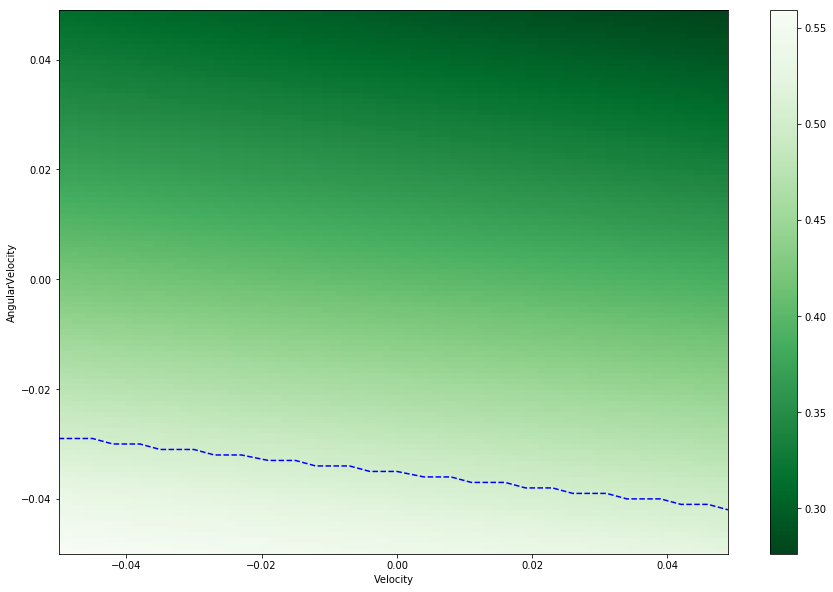

In [55]:
x, y = np.meshgrid(velocity_range, angular_velocity_range)
data = np.concatenate((np.zeros_like(y)[np.newaxis], 
                          x[np.newaxis], 
                          np.zeros_like(y)[np.newaxis],
                          y[np.newaxis]), axis=0)
data = data.reshape((4,-1)).T
probability = np.zeros(shape=(data.shape[0],))
for i in range(data.shape[0]):
    probability[i] = agent.ses.run(soft_max, feed_dict={agent.input: data[i,:][np.newaxis]})[0][0]
probability = np.reshape(probability, (velocity_range.shape[0], angular_velocity_range.shape[0]), order='F')
line_x, line_y = np.where(np.abs(probability-0.5)<1e-3)
print("Probability of choosing left action")
plt.figure(figsize=(15,10))
plt.pcolormesh(angular_velocity_range, velocity_range, probability.T, cmap=plt.cm.Greens_r)
plt.colorbar()
plt.plot(velocity_range[line_x],angular_velocity_range[line_y],'b--')
plt.xlabel("Velocity")
plt.ylabel("AngularVelocity")
plt.show()